In [5]:
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.get_device_name()

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

## Getting data

In [7]:
## General params
num_classes = 10
batch_size = 64
input_size = 224
RESNET_PATH_C = './resnet18_c_augm1.pth'

In [8]:
# r_crop = T.RandomResizedCrop(244)
# resize = T.Resize(244)
# img = torch.rand((3,30,30))
# print(img)

# plt.imshow(np.transpose(img.numpy(), (1,2,0)))
# plt.show()

# img1 = r_crop(img)
# plt.imshow(np.transpose(img1.numpy(), (1,2,0)))
# plt.show()
# print(img1.shape)

# img2 = r_crop(img)
# plt.imshow(np.transpose(img2.numpy(), (1,2,0)))
# plt.show()
# print(img2.shape)

In [9]:
transform = T.Compose([
    T.RandomAffine(degrees=(0,15), translate=(0.1, 0.3), scale=(0.75, 1.0)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
print('train + val:',trainset)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
print('train set:',trainset.dataset)
print('val set:', valset.dataset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
train + val: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[0.0, 15.0], translate=(0.1, 0.3), scale=(0.75, 1.0))
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomAutocontrast(p=0.5)
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
train set: Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomAffine(degrees=[0.0, 15.0], translate=(0.1, 0.3), scale=(0.75, 1.0))
               RandomAdjustSharpness(sharpness_factor=2,p=0.5)
               RandomAutocontrast(p=0.5)
               Resize(size=224, interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5

In [10]:
mask_500 = []
count_by_class = [0]*10
for i in range(40000):
    _, label = trainset.dataset[i]
    if count_by_class[label] < 500:
        mask_500.append(i)
        count_by_class[label] +=1
print(len(mask_500))
print(count_by_class)

5000
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


In [11]:
tiny_trainset = torch.utils.data.Subset(trainset, mask_500)
tiny_trainloader = torch.utils.data.DataLoader(tiny_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
print(type(tiny_trainloader.dataset))

<class 'torch.utils.data.dataset.Subset'>


In [12]:
## Not using auto augment as they are already trained on some datasets 
# augmented_train_set = []

# affine_transfomer = T.RandomAffine(degrees=(10, 30), translate=(0.1, 0.3), scale=(0.75, 1.0))
# sharpness_adjuster = T.RandomAdjustSharpness(sharpness_factor=2)
# autocontraster = T.RandomAutocontrast()

# for image, label in tiny_trainset:
#     augmented_train_set.append([image, label])
#     aug_image = []
#     aug_image.append(affine_transfomer(image))
#     aug_image.append(affine_transfomer(image))
#     aug_image.append(sharpness_adjuster(image))
#     aug_image.append(autocontraster(image))
#     for img in aug_image:
#         augmented_train_set.append([img, label])

# print(len(augmented_train_set))


In [13]:
# augmented_train_loader = torch.utils.data.DataLoader(tiny_trainset, batch_size=batch_size,
#                                                     shuffle=True, num_workers=2)

In [14]:
dataloader_dict = {
    'train': tiny_trainloader,
    'val': valloader
}

# aug_dataloader ={
#     'train': augmented_train_loader,
#     'val': valloader
# }
# print('complete dataloader:',dataloader_dict)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
# count =0 
# for image, label in dataloader_dict['train']:
#     count+=1
# print(count)
# 79 batches

start transforming


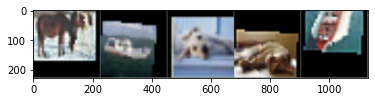

horse      ship       dog        cat        ship      


In [16]:
## Checking out some training images


# functions to show an image
def imshow(img):
    print('start transforming')
    img = img / 2 + 0.5     # unnormalize
    # print('1')
    npimg = img.numpy()
    # print('2')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # print('3')
    plt.show()


# get some random training images
dataiter = iter(tiny_trainloader)
# dataiter = iter(augmented_train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(5)))

In [18]:
## Advanced pytorch train function
import time
import copy
val_acc_history = []
train_acc_history = []
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    # val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [19]:
from raw_resnet import resnet18, ResNetBasicCustomBlock

resnet18_c = resnet18(3, 10,block=ResNetBasicCustomBlock)
resnet18_c = resnet18_c.to(device)

In [32]:
learning_rate = 1e-2
num_epochs = 20
optimizer = optim.Adam(resnet18_c.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [33]:
continue_train = True
if continue_train:
    resnet18_c.load_state_dict(torch.load(RESNET_PATH_C))
val_acc_history = []
train_acc_history = []
resnet18_c, val_acc, train_acc = train_model(resnet18_c, dataloader_dict,
                               criterion, optimizer,num_epochs,is_inception=False)

Epoch 0/19
----------
train Loss: 0.9279 Acc: 0.6674
val Loss: 1.2427 Acc: 0.5713

Epoch 1/19
----------
train Loss: 0.8632 Acc: 0.6912
val Loss: 1.2500 Acc: 0.5790

Epoch 2/19
----------
train Loss: 0.8365 Acc: 0.6978
val Loss: 1.2251 Acc: 0.5941

Epoch 3/19
----------
train Loss: 0.7686 Acc: 0.7284
val Loss: 1.2527 Acc: 0.5943

Epoch 4/19
----------
train Loss: 0.7640 Acc: 0.7270
val Loss: 1.5010 Acc: 0.5256

Epoch 5/19
----------
train Loss: 0.6988 Acc: 0.7506
val Loss: 1.3075 Acc: 0.5774

Epoch 6/19
----------
train Loss: 0.6846 Acc: 0.7628
val Loss: 1.1441 Acc: 0.6284

Epoch 7/19
----------
train Loss: 0.6665 Acc: 0.7662
val Loss: 1.1587 Acc: 0.6314

Epoch 8/19
----------
train Loss: 0.6278 Acc: 0.7778
val Loss: 1.1746 Acc: 0.6236

Epoch 9/19
----------
train Loss: 0.5778 Acc: 0.8028
val Loss: 1.2678 Acc: 0.6132

Epoch 10/19
----------
train Loss: 0.5687 Acc: 0.8024
val Loss: 1.2100 Acc: 0.6219

Epoch 11/19
----------
train Loss: 0.5179 Acc: 0.8164
val Loss: 1.1138 Acc: 0.6446

Ep

In [34]:
torch.save(resnet18_c.state_dict(), RESNET_PATH_C)

In [35]:
val_accuracy = []
train_accuracy = []
for acc in val_acc_history:
    val_accuracy.append(acc.item())
for acc in train_acc_history:
    train_accuracy.append(acc.item())

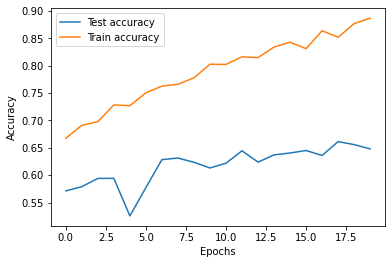

In [36]:
## Plotting the accuracies
import matplotlib.pyplot as plt
# test_acc = [acc.data for acc in test_epoch_acc]

plt.plot(val_accuracy, label='Test accuracy')
plt.plot(train_accuracy, label='Train accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
# class resnet18c_drop(nn.modules):
#     def __init__(self):
#         super(resnet18c_drop, self).__init__()
#         self.model = models.resnet18(pretrained=False)
#         self.droupout = nn.Dropout(0.5)
        
#     def forward(self, x):
#         x = self.model.conv1(x)
#         x = self.model.bn1(x)
#         x = self.model.relu(x)
#         x = self.model.maxpool(x)
#         x = self.droupout(x)
        
#         x = self.model.layer1(x)
#         x = self.model.layer2(x)
#         x = self.model.layer3(x)
#         x = self.model.layer4(x)

#         x = self.model.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.model.fc(x)
        
#         return x
            

In [31]:
# resnet18_c = models.resnet18(pretrained=False)
# resnet18_c = resnet18_c.to(device)